# Computation of eke

In [1]:
#!/usr/bin/env python

from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
cluster


cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.5.212:36109
distributed.scheduler - INFO -   dashboard at:                     :8787


In [2]:

client = Client(cluster)

client

distributed.scheduler - INFO - Receive client connection: Client-042f32d0-103f-11ea-8acb-c249a457f033
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.5.212:36109 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [16]:
import sys

import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

import numpy.ma as ma

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt


%matplotlib inline



In [4]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import zarr


In [5]:
import time
import gcsfs


In [6]:
%time

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')
gcs = gcsfs.GCSFileSystem(gcs=fs,check=False,create=False)

mapzarru = gcs.get_mapper('pangeo-data/eNATL60-BLBT02-SSU-1h')
dsu = xr.open_zarr(mapzarru)

mapzarrv = gcs.get_mapper('pangeo-data/eNATL60-BLBT02-SSV-1h')
dsv = xr.open_zarr(mapzarrv)



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


distributed.scheduler - INFO - Register tcp://10.32.15.3:39095
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.15.3:39095
distributed.core - INFO - Starting established connection


In [7]:
%%time
lat=dsu['nav_lat']
lon=dsu['nav_lon']
 
# definition of the area

latmin = 40.0; latmax = 41.0;
lonmin = -40.0; lonmax = -39.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]


distributed.scheduler - INFO - Register tcp://10.32.22.3:43765
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.3:43765
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.22.2:36163
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.2:36163
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.21.4:42839
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.21.4:42839
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.21.2:35963
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.21.2:35963
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.19.3:34021
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.19.3:34021
distributed.core - INFO

CPU times: user 27.2 s, sys: 2.56 s, total: 29.7 s
Wall time: 42.6 s


In [8]:
%%time

print('Select dates')
u_JFM=dsu.sel(time_counter=slice('2010-01-01','2010-03-31'))['sozocrtx']
v_JFM=dsv.sel(time_counter=slice('2010-01-01','2010-03-31'))['somecrty']


print('Select box area')
u_JFM_box=u_JFM[:,jmin:jmax,imin:imax].chunk({'time_counter':10,'x':120,'y':120})
v_JFM_box=v_JFM[:,jmin:jmax,imin:imax].chunk({'time_counter':10,'x':120,'y':120})


Select dates
Select box area
CPU times: user 503 ms, sys: 173 ms, total: 675 ms
Wall time: 660 ms


In [9]:
u_JFM

<xarray.DataArray 'sozocrtx' (time_counter: 2160, y: 4729, x: 8354)>
dask.array<getitem, shape=(2160, 4729, 8354), dtype=float32, chunksize=(24, 120, 120), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(296, 1045), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(296, 1045), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 40 s)
    interval_operation:  40 s
    interval_write:      1 h
    long_name:           ocean surface current along i-axis
    online_operation:    average
    units:               m/s

In [10]:
# u and v are not on the same grid that is why we shift
def compute_TKE(u,v):
    ua=0.5*(u*u+u.shift(x=-1)*u.shift(x=-1))
    va=0.5*(v*v+v.shift(y=-1)*v.shift(y=-1))
    eke=0.5*(ua+va)
    return eke

In [11]:
tke_JFM_box=compute_TKE(u_JFM_box,v_JFM_box)

In [12]:
tke_JFM_box

<xarray.DataArray (time_counter: 2160, y: 77, x: 59)>
dask.array<mul, shape=(2160, 77, 59), dtype=float32, chunksize=(10, 77, 59), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 40.000576 40.00074 ... 40.989346 40.98952
    nav_lon        (y, x) float32 -39.985954 -39.96919 ... -39.04693 -39.03014
    time_centered  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-31T23:30:00
  * time_counter   (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: y, x

Text(0.5, 1.08, 'EKE JFM no filter')

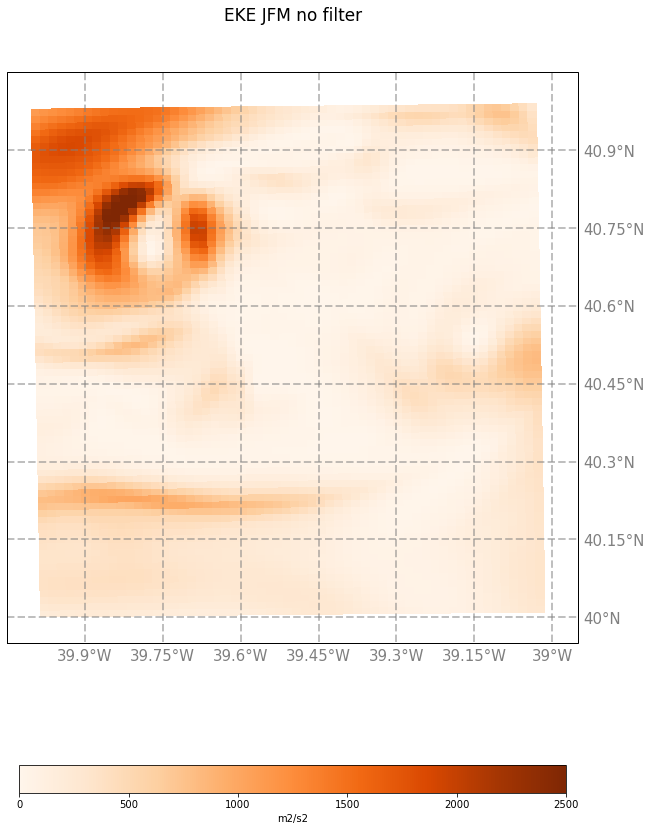

In [24]:
#taht is the real data
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))

cmap = plt.get_cmap('Oranges')
ax.set_extent([-40.05, -38.95, 39.95, 41.05])
cmap.set_under(color='grey')
pcolor=ax.pcolormesh(lonbox,latbox,10000*tke_JFM_box[100],transform=ccrs.PlateCarree(),cmap=cmap,vmin=0,vmax=2500)
ax.add_feature(cfeature.LAND,facecolor='grey')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator(np.arange(-40.05,-38,0.15))
gl.ylocator = mticker.FixedLocator(np.arange(39.85,41.2,0.15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.xlabels_top = False
gl.ylabels_left = False

cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m2/s2')
ax.set_title('EKE JFM no filter',size=17,y=1.08)


Text(0.5, 1.08, 'EKE JFM no filter')

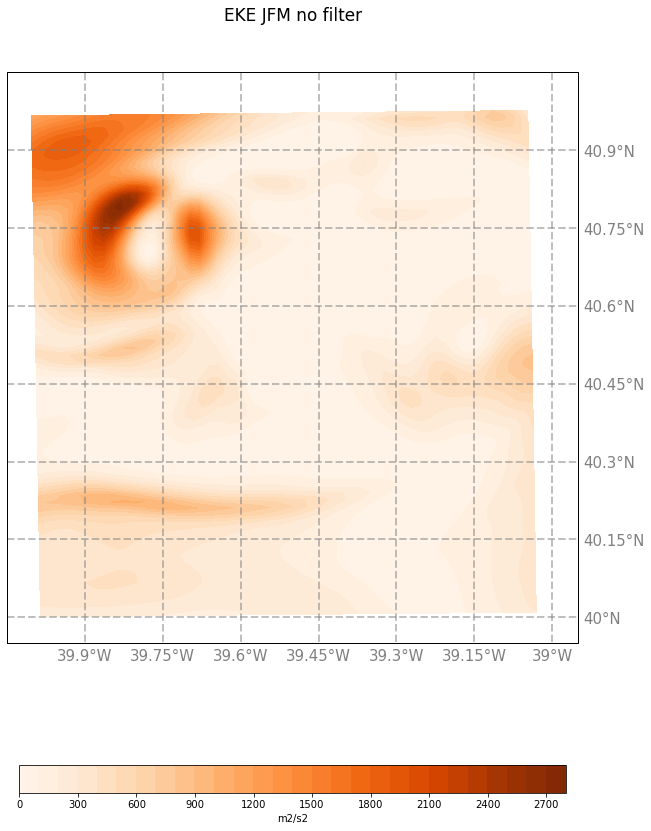

In [31]:
#that is interpolated data (more beautiful)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))

cmap = plt.get_cmap('Oranges')
ax.set_extent([-40.05, -38.95, 39.95, 41.05])
cmap.set_under(color='grey')
pcolor=ax.contourf(lonbox,latbox,10000*tke_JFM_box[100],np.arange(0,2900,100),transform=ccrs.PlateCarree(),cmap=cmap)
ax.add_feature(cfeature.LAND,facecolor='grey')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator(np.arange(-40.05,-38,0.15))
gl.ylocator = mticker.FixedLocator(np.arange(39.85,41.2,0.15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
gl.xlabels_top = False
gl.ylabels_left = False

cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m2/s2')
ax.set_title('EKE JFM no filter',size=17,y=1.08)


In [ ]:
#to make 3 plots in one line replace 
# ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30)) 
#by ax = fig.add_subplot(131,projection=ccrs.PlateCarree(central_longitude=-30))
#then do the first plot
#then ax = fig.add_subplot(132,projection=ccrs.PlateCarree(central_longitude=-30))
#do the second plot
#etc
#change the figure size accordingly